# Beyond Predictive Models- *What if* my rejected loan application got accepted?

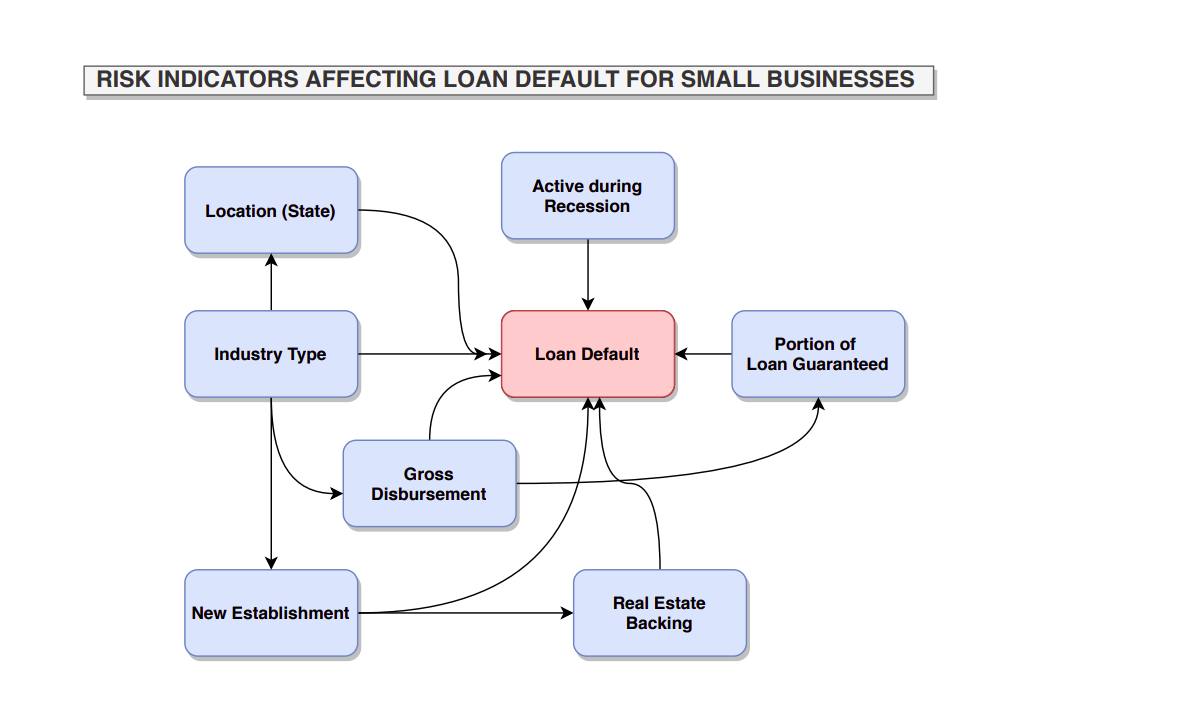


In the recent years we have seen an acute rise in the adoption of Machine Learning by businesses to make *Data-Driven* decisions. One of the several industries making immense use of it is the Finance Industry wherein machine learning is increasingly being used to solve problems in *Portfolio Management*, *Algorithmic Trading*, *Fraud Detection* etc. Here we focus on one particular application, i.e. to gain a better understanding of **Loan Defaults** so as to minimize them. Using past data, a straightforward application of machine learning would be to design a predictive model which can accurately predict the probability of default. This model would then be used in tandem with the loan officers instincts to decide as to whether the loan application should be approved or not. 

But is that score generated by a black box machine learning classifier enough for the loan officer to make his decision? In addition, what if the applicant who has just been denied the loan asks for an explanation. Will the loan officer be able to explain the decision made by the black box? or simply what the applicant should do differently in order to get an approval? In extreme cases, a highly accurate model might also be biased towards a particular gender, race which would ultimately hurt the banks reputation for being unethical.

In this case study we consider a large and rich dataset from the U.S. Small Business Administration (SBA). Our task is to create a ML Classifier which can accurately predict the probability of default and can assist the loan officer in answering:-
***As a representative of the bank, should I grant this loan to a particular small business (Company 'X')? Why or why not? If not, then what should 'X' do differently in order to secure an approval?***

This notebook is divided into 2 parts, in ***Part-I***, we focus on feature engineering based on domain knowledge and design accurate predictive models.

In ***Part-II***, we shift our focus towards explaining individual predictions made by the black box classifier designed in *Part-I* through *diverse* counterfactual explantions which lie in the *vicinity* of the original instance being evaluated. An vital aspect of our explanations would also involve probing the model to dig out the latent biases(if any) embedded deep inside the model.

## Part-I: Designing Predictive Models

### a) Data Cleaning

A raw version of the dataset ('SBANational.csv') associated with this notebook can be downloaded [here](https://www.tandfonline.com/doi/suppl/10.1080/10691898.2018.1434342?scroll=top)

In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [58]:
# Read dataset and store date in the correct format
dataset = pd.read_csv('SBAnational.csv')
print('The shape of the dataset is: ',dataset.shape)
from datetime import datetime
date_list = list(dataset['ApprovalDate'])
date_list_updated = list()
for date_str in date_list:
    d = datetime.strptime(date_str,'%d-%b-%y')
    date_list_updated.append(d)
dataset['ApprovalDate']=date_list_updated
dataset.sample(10)

/home/siddharth/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The shape of the dataset is:  (899164, 27)


,LoanNr_ChkDgt,Name,City,State,Zip,Bank,BankState,NAICS,ApprovalDate,ApprovalFY,...,RevLineCr,LowDoc,ChgOffDate,DisbursementDate,DisbursementGross,BalanceGross,MIS_Status,ChgOffPrinGr,GrAppv,SBA_Appv
733213,7626714000,DATABASES BY DESIGN,BONITA,CA,91902,BBCN BANK,CA,541511,2004-07-21,2004,...,0,N,14-Feb-06,31-Jul-04,"$5,000.00",$0.00,CHGOFF,"$4,681.00","$5,000.00","$4,250.00"
626738,6224144009,"GAMELENDER, LLC",SAN JOSE,CA,95120,BANK OF AMERICA NATL ASSOC,NC,512199,2003-04-04,2003,...,Y,N,NaN,31-May-03,"$10,400.00",$0.00,P I F,$0.00,"$10,000.00","$5,000.00"
629248,6249453008,"POLSON READY MIX CONCRETE, INC",MISSOULA,MT,59807,U.S. BANK NATIONAL ASSOCIATION,MT,327320,1994-02-22,1994,...,N,N,NaN,31-Jul-94,"$913,500.00",$0.00,P I F,$0.00,"$913,500.00","$685,125.00"
506026,4898024005,AUNTIE ANNE'S,OLATHE,KS,66061,BANK OF AMERICA NATL ASSOC,NC,722213,2001-09-10,2001,...,0,N,NaN,30-Sep-01,"$144,453.00",$0.00,P I F,$0.00,"$150,000.00","$127,500.00"
64482,1487374007,ALAMITOS BAY MARKET,LONG BEACH,CA,90803,HANMI BANK,CA,0,1997-08-16,1997,...,N,N,NaN,31-Oct-97,"$330,000.00",$0.00,P I F,$0.00,"$330,000.00","$247,500.00"
708811,7371624005,RUSTY NAIL LLC,STOWE,VT,5672,VERMONT 504 CORPORATION,VT,722410,2004-04-21,2004,...,N,N,NaN,14-Jul-04,"$470,000.00",$0.00,P I F,$0.00,"$470,000.00","$470,000.00"
532632,5195223008,NMT ASSOCIATES,WINTER PARK,FL,32789,TRANSAMERICA SMALL BUS. CAPITA,SC,0,1992-10-20,1993,...,N,N,NaN,31-Jan-93,"$242,000.00",$0.00,P I F,$0.00,"$242,000.00","$205,700.00"
541612,5308354005,FONTANA CHEVRON,FONTANA,CA,92335,FIRST-CITIZENS BK & TR CO,NC,447110,2002-03-29,2002,...,0,N,NaN,31-May-02,"$718,800.00",$0.00,P I F,$0.00,"$718,800.00","$539,100.00"
212753,2502096002,SASSAFRAS RESTAURANT,FAYETTEVILLE,AR,72701,IBERIABANK,AR,722110,2006-10-31,2007,...,0,N,NaN,31-Dec-06,"$380,000.00",$0.00,P I F,$0.00,"$380,000.00","$285,000.00"
437088,4241134009,"ANN N. HEBDA, D.D.S., P.C.",ASHBURN,VA,20147,"BUSINESS FINANCE GROUP, INC.",VA,621210,2001-01-24,2001,...,N,N,NaN,12-Jun-02,"$178,000.00",$0.00,P I F,$0.00,"$178,000.00","$178,000.00"


### b) Feature Engineering

There are a number of variables that consistently emerge as indicators of risk that could explain the variation of loan default rates. Seven variables that are discussed below include *Location (State), Industry, Gross Disbursement, New versus Established Business, Loans Backed by Real Estate, Economic Recession, and SBA’s Guaranteed Portion of Approved Loan*.

Based on domain knowledge and the work done by [M.Li et al. 2017](https://amstat.tandfonline.com/doi/full/10.1080/10691898.2018.1434342), we create the following new features:-

#### 1) Default (*Response Variable*) 
Response variable *'Default'* attains the value 1 if *MIS_Status='CHGOFF'*, and 0 otherwise.

In [59]:
dataset['Default']=0
dataset.loc[dataset['MIS_Status']=='CHGOFF','Default']=1 #Default if MIS_Status = CHGOFF
#dataset.sample(10)

#### 2) Was the Loan active during the Great Recession?
Creating a new feature ***Recession*** which denotes whether the loan was active during the recession period (b/w 1/12/2007 to 31/06/2009). A dummy variable ***“Recession”*** where ***“Recession”*** is 1 if the loans were active in between  December 2007 to June 2009, and equals 0 for all other times.

In [60]:
dataset['Recession']=0
dataset.loc[dataset['ApprovalDate']>='2007-12-01','Recession']=1
dataset.loc[dataset['ApprovalDate']>='2009-06-30','Recession']=0
#dataset.sample(10)

#### 3) Is the loan backed by real estate?
Creating a new feature ***Backed_by_real_estate*** which denotes whether the loan was backed by real estate or not. Loans that are backed by real estate generally have terms greater than 20 years, so our newly created feature takes the value as 1, if the term is greater than 20 years and 0 otherwise. 

In [61]:
dataset['Backed_by_Real_Estate']=0
dataset.loc[dataset['Term']>=240,'Backed_by_Real_Estate']=1 
#dataset.sample(10)

#### 4) Which industry category did the small business seeking loan belong to?

Creating a new feature ***Industry_code*** which tells us which category the given company belongs to. By default, the industry code is present in the first two characters of NAICS.
The industry codes are as follows:-

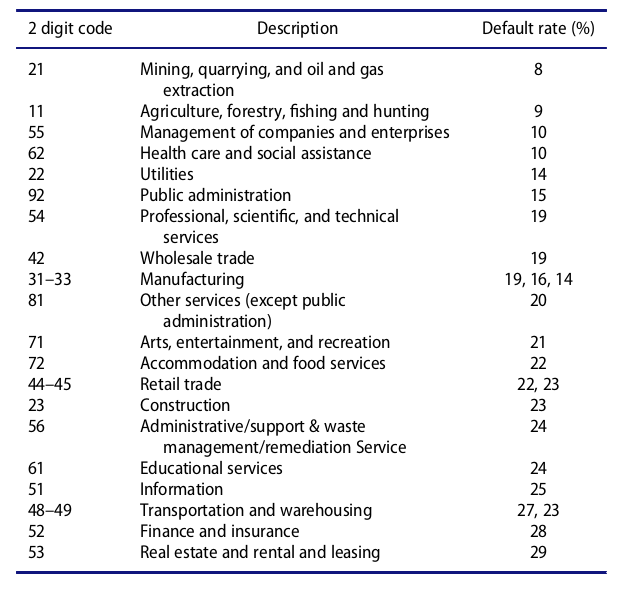

Table taken from: [M.Li et al. 2017](https://amstat.tandfonline.com/doi/full/10.1080/10691898.2018.1434342)

In [62]:
# Extract Industry Code from NAICS to create a new Industry Feature
dataset['Industry']=dataset['NAICS'].astype('str').str[0:2]

#### 5) How much *portion* of the loan amount is guaranteed by SBA?
Another risk indicator ***Portion*** was engineered which represents the percentage of the loan that is guaranteed by SBA. This is one of the variables generated by calculating the ratio of the
amount of the loan SBA has been guaranteed and the gross amount approved by the bank. A *guaranteed loan* is a type of loan in which a third party agrees to pay if the borrower should default and is used by borrowers with poor credit or little in the way of financial resources; it enables financially unattractive candidates to qualify for a loan and assures that the lender won't lose money.

$Portion = \frac{SBA_{Approved}}{Gross_{Approved}} $

In [63]:
dataset['SBA_Appv'] = dataset['SBA_Appv'].str.replace(',', '').str.replace('$', '').str.replace('.', '').astype(int)
dataset['GrAppv'] = dataset['GrAppv'].str.replace(',', '').str.replace('$', '').str.replace('.', '').astype(int)
dataset['Portion']=dataset['SBA_Appv']/dataset['GrAppv']

We create a plot to check the distribution of Default v/s Non-Default Cases over the years. There seems to be a high default rate from 2006 till 2008.

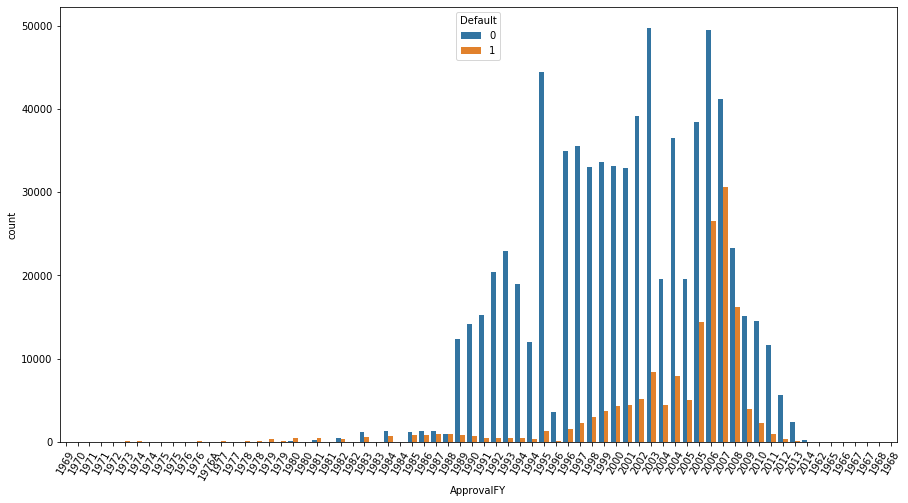

In [64]:
import seaborn as sns
plt.figure(figsize=(15,8))
dataset_sorted = dataset.sort_values(by='ApprovalDate')
ax = sns.countplot(x='ApprovalFY',hue='Default',data=dataset_sorted)
plt.xticks(rotation=60)
plt.show()

#### 6) What is the total amount disbursed?
Gross disbursement (represented as ***“DisbursementGross”*** in the dataset) is another risk indicator identified as a key variable to consider. The rationale behind selecting ***“DisbursementGross”*** is that the larger the loan size, the more likely the underlying business will be established and expanding (i.e., purchasing assets that have some resale value), thereby increasing the likelihood of paying off the loan.


#### 7 & 8. 
Finally we claim that the Location of the company represented by ***State*** and whether its a newly established company or not might also serve as potential risk indicator. It may be argued that established businesses already
have a proven track record of success and are requesting a loan to expand on what they already do successfully. Whereas, new businesses sometimes do not anticipate the obstacles they may face and may be unable to successfully. So a feature ***NewExist*** was engineered, which attains the value = 1 if the business is less than 2 years old and 0 if the business is more than 2 years old.

In [65]:
dataset_shortlisted = dataset_sorted[['State','Industry','DisbursementGross','NewExist','Backed_by_Real_Estate',
                                     'Recession','Portion', 'Default']]
dataset_shortlisted = dataset_shortlisted.dropna()

This is how our final dataset looks like. Using these risk indicators we will now focus on designing Classifiers.

In [66]:
dataset_shortlisted['DisbursementGross'] = dataset_shortlisted['DisbursementGross'].str.replace(',', '').str.replace('$', '').str.replace('.', '').astype(int)
dataset_shortlisted['NewExist']=dataset_shortlisted['NewExist'].astype(int)
dataset_shortlisted.sample(10)

,State,Industry,DisbursementGross,NewExist,Backed_by_Real_Estate,Recession,Portion,Default
408738,MN,44,15000000,1,0,0,0.75,1
276740,NY,54,2500000,1,0,1,0.50,0
232605,CA,0,50000000,1,1,0,1.00,0
178854,FL,54,949800,2,0,0,0.50,0
34024,MS,54,16700000,1,1,0,1.00,0
28858,NY,48,1266700,1,0,0,0.50,1
322578,CA,0,32850000,1,1,0,0.75,0
312876,NM,54,5400000,1,0,0,0.80,0
122868,MI,44,2530000,1,0,0,0.50,0
298624,PA,33,5000000,1,0,1,0.50,0


In [67]:
# Check counts of New v/s Established Companies
dataset_shortlisted['NewExist'].value_counts()

1    644860
2    253121
0      1033
Name: NewExist, dtype: int64

In [68]:
# NewExist contains some values as 0 which does not carry any significance, so we remove them
dataset_shortlisted=dataset_shortlisted.loc[(dataset_shortlisted.NewExist == 1) | (dataset_shortlisted.NewExist == 2),:]

One Hot Encode all the categorical columns present in the dataset

In [69]:
dataset_encoded= pd.get_dummies(dataset_shortlisted,columns=['Industry','State'])
dataset_encoded.shape

(897981, 82)

As expected.There is a clear class imbalance present in the dataset!

In [70]:
dataset_encoded['Default'].value_counts()

0    740501
1    157480
Name: Default, dtype: int64

## Treating Data for Imbalanced Classification
As seen above, the distribution of *Default* v/s *Not-Default* classes in our dataset is highly skewed. If we go on to train models on this dataset, then even the best performing models would give us misleading results. So it might happen that even though the overall accuracy would be high(falsely) but the model would not be working well in idenifying default cases(Low Specificity and Low Kappa Scores).

There are several methods which can be used to treat imbalanced class problems but since we have access to a good amount of instances for each class, therefore we simply downsample instances from the majority class (**Non-Default**) to match the minority class (**Default**)

In [71]:
dataset_bal_0 = dataset_encoded[dataset_encoded['Default'].isin(["0"])].sample(157480,random_state=26)
dataset_bal_1 = dataset_encoded[dataset_encoded['Default'].isin(["1"])]
dataset_balanced = pd.concat([dataset_bal_0,dataset_bal_1])#.sample(26000,random_state=26)

# Artificial Neural Network

We tried out several linear and non-linear Machine Learning Classifiers and the best performing linear classifier (Logistic Reg.) gave us a balanced accuracy of 50% whereas the non-linear classifier(XGBoost) gave us a balanced accuracy of 70%.

Keeping the [Universal approximation theorem](http://cognitivemedium.com/magic_paper/assets/Hornik.pdf) in mind we construct a single layer ANN Classifier which will be used as an input to *DiCE* for generating counterfactuals. After experimenting with different choices of hyperparameters, the architechture described below gave us the best validation score on several metrics.

In [72]:
# supress deprecation warnings from TF
import tensorflow as tf
from tensorflow import keras
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(26)
# Adjusting for class imbalance by downsampling
dataset_bal_0 = dataset_shortlisted[dataset_shortlisted['Default'].isin(["0"])].sample(157480,random_state=26)
dataset_bal_1 = dataset_shortlisted[dataset_shortlisted['Default'].isin(["1"])]
dataset_balanced_dice = pd.concat([dataset_bal_0,dataset_bal_1])
import dice_ml
sess = tf.compat.v1.InteractiveSession()
d = dice_ml.Data(dataframe=dataset_balanced_dice, continuous_features=['DisbursementGross', 'NewExist',
       'Backed_by_Real_Estate', 'Recession', 'Portion'], outcome_name='Default')
train, _ = d.split_data(d.normalize_data(d.one_hot_encoded_data))
X_train = train.loc[:, train.columns != 'Default']
y_train = train.loc[:, train.columns == 'Default']
X_train.head()

from sklearn.metrics import roc_auc_score
METRICS = [
      #keras.metrics.TruePositives(name='tp'),
      #keras.metrics.FalsePositives(name='fp'),
      #keras.metrics.TrueNegatives(name='tn'),
      #keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
]

ann_model = keras.Sequential()
ann_model.add(keras.layers.Dense(200, input_shape=(X_train.shape[1],), 
                                 kernel_regularizer=keras.regularizers.l2(0.001), 
                                 activation=tf.nn.relu))
ann_model.add(keras.layers.Dense(1, activation=tf.nn.sigmoid))

ann_model.compile(loss='binary_crossentropy', 
                  optimizer=tf.keras.optimizers.Adam(0.001), 
                  metrics=METRICS)#=['accuracy',auroc])
ann_model.fit(X_train, y_train, validation_split=0.20, epochs=26, verbose=1)
# the training will take some time for 26 epochs.
# you can wait or set verbose=1 or 0 to see(not see) the progress of training.

/home/siddharth/.local/lib/python3.7/site-packages/tensorflow/python/client/session.py:1751: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


Epoch 1/26
6300/6300 [==============================] - 12s 2ms/step - loss: 0.6165 - accuracy: 0.6597 - precision: 0.6379 - recall: 0.7422 - auc: 0.7179 - val_loss: 0.6055 - val_accuracy: 0.6675 - val_precision: 0.6493 - val_recall: 0.7320 - val_auc: 0.7277
Epoch 2/26
6300/6300 [==============================] - 12s 2ms/step - loss: 0.6080 - accuracy: 0.6634 - precision: 0.6417 - recall: 0.7434 - auc: 0.7230 - val_loss: 0.6064 - val_accuracy: 0.6653 - val_precision: 0.6473 - val_recall: 0.7296 - val_auc: 0.7262
Epoch 3/26
6300/6300 [==============================] - 10s 2ms/step - loss: 0.6065 - accuracy: 0.6645 - precision: 0.6430 - recall: 0.7428 - auc: 0.7247 - val_loss: 0.6024 - val_accuracy: 0.6677 - val_precision: 0.6365 - val_recall: 0.7860 - val_auc: 0.7305
Epoch 4/26
6300/6300 [==============================] - 10s 2ms/step - loss: 0.6051 - accuracy: 0.6654 - precision: 0.6439 - recall: 0.7436 - auc: 0.7259 - val_loss: 0.6010 - val_accuracy: 0.6699 - val_precision: 0.6463 - v

## Enter *DiCE*
## Part- II: Counterfactual Explanations for individual instances using the trained model
Now that we have trained a black box classifier to identify default cases, we aim to generate explanations which can assist the loan officer in making an informed decision and at the same time provide actionable insights so that even if the applicant is denied a loan at present, they can secure it in the future after encorporating the suggested changes.

Given a trained classifier and the instance needing explanation, [*DiCE*](https://arxiv.org/abs/1905.07697) focuses on generating a set of counterfactual explanations by adressing a ***diversity-proximity*** tradeoff. 
In addition to facilitate actionability, *DiCE* is flexible enough to support user-provided inputs based on domain knowledge, such as custom weights for individual features (A higher feature weight means that the feature is harder to change than others) and restrictions on the perturbation of certain features that are difficult to modify in the real world.

In [73]:
# provide the trained ML model to DiCE's model object
backend = 'TF'+tf.__version__[0]
m = dice_ml.Model(model=ann_model, backend=backend)

## Generate diverse counterfactuals
Based on the data object *d* and the model object *m*, we can now instantiate the DiCE class for generating explanations.

In [74]:
# initiate DiCE
exp = dice_ml.Dice(d, m)

## Would a loan be granted to a Real Estate business based in New York during COVID'19?

Let us consider a newly established small business based in *New York* that advertizes itself to be the best in helping fellow new yorkers and newcomers in finding the right apartment to rent (despite the abnormally high costs of real estate in New York!). It goes to JP Morgan & Chase and puts forward their case before a loan officer requesting for a loan of USD 125,000. To make their application strong, they have a guranteed payback of USD 112,500 (*Portion=90%*) which will be paid by a third party in case of default. However, at this stage they don't have any backing in the form of real estate which can be used by the bank in case of default. Another important point to note is that the US Job market is going through recession right now due to COVID'19.

We now provide this instance (in the form of a 7-d vector) whose decision will first be evaluated by our ANN Classifier and then explained by *DICE*.

In [75]:
# query instance in the form of a dictionary; keys: feature name, values: feature value
query_instance = {'State': 'NY', 'Industry': '53', 'DisbursementGross': 125000, 'NewExist': 1, 'Backed_by_Real_Estate': 0, 'Recession': 1, 'Portion': 0.90}
print("Counterfactual sample: {}".format(query_instance))

Counterfactual sample: {'State': 'NY', 'Industry': '53', 'DisbursementGross': 125000, 'NewExist': 1, 'Backed_by_Real_Estate': 0, 'Recession': 1, 'Portion': 0.9}


## Try-1. Naive use of DiCE
We start by generating counterfactuals using default parameter values so as to know what all needs to be tweaked.

The results obtained suggest that we might need to restrict change in some features that are difficult to change in the real world. Also continous features might need a scaling factor to prevent them from attaining abnormally high values in the generated counterfactuals.

In [76]:
# generate counterfactuals
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite")
# visualize the resutls by highlighting only the changes
dice_exp.visualize_as_dataframe(show_only_changes=True)

Diverse Counterfactuals found! total time taken: 00 min 21 sec
Query instance (original outcome : 1)


,State,Industry,DisbursementGross,NewExist,Backed_by_Real_Estate,Recession,Portion,Default
0,NY,53,125000.0,1.0,0.0,1.0,0.9,0.841555



Diverse Counterfactual set (new outcome : 0)


,State,Industry,DisbursementGross,NewExist,Backed_by_Real_Estate,Recession,Portion,Default
0,NH,21,0.0,-,1.0,0.0,0.3,0.082
1,VT,-,0.0,-,1.0,-,1.0,0.025
2,ND,42,16777763.0,-,1.0,-,0.8,0.066
3,-,-,59944280.0,-,1.0,-,-,0.09


## Try-2. Slightly better use of DiCE

We notice 2 major problems in the counterfactuals being generated in Try-1:-

1) **Model biased towards certain State's and Industry type's**- Given that *New York* witnesses comparably high default percentages (with *California* being the highest) and that the *Real-Estate* Industry also has the highest default percentage, there seems to be some bias towards these two categories. This is confirmed when the generated counterfactuals suggest to change *State* and *Industry-Type* respectively. 
Removing *State* & *Industry-type* from the *features_to_change* list can solve this problem.



2) **Abnormally high values for *GrossDisbursement***- It may be the case that some features are harder to change than others(In our case *DisbursementGross* seem to attain erratic values). DiCE allows input of relative difficulty in changing a feature through specifying feature weights. A higher feature weight means that the feature is harder to change than others. For instance, one way is to use the mean absolute deviation from the median as a measure of relative difficulty of changing a continuous feature. Let's see what their values are by computing them below:

In [77]:
# get MAD
mads = d.get_mads(normalized=True)

# create feature weights
feature_weights = {}
for feature in mads:
    feature_weights[feature] = round(1/mads[feature], 2)
print(feature_weights)

{'DisbursementGross': 130.1, 'NewExist': inf, 'Backed_by_Real_Estate': inf, 'Recession': inf, 'Portion': 6.13}


/home/siddharth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in double_scalars
  import sys


In [78]:
# Assigning custom weight for Gross Disbursement because counterfactuals being generated are having higher values of this feature.
feature_weights = {'DisbursementGross': 13000, 'Portion': 1} # Setting weight of DisbursementGross to 130.1 still gave bad results, so we went for an even higher value  
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite",feature_weights=feature_weights ,
                                        features_to_vary=['DisbursementGross','NewExist','Backed_by_Real_Estate','Recession','Portion'])
# visualize the results by highlighting only the changes
dice_exp.visualize_as_dataframe(show_only_changes=True)

Diverse Counterfactuals found! total time taken: 03 min 20 sec
Query instance (original outcome : 1)


,State,Industry,DisbursementGross,NewExist,Backed_by_Real_Estate,Recession,Portion,Default
0,NY,53,125000.0,1.0,0.0,1.0,0.9,0.841555



Diverse Counterfactual set (new outcome : 0)


,State,Industry,DisbursementGross,NewExist,Backed_by_Real_Estate,Recession,Portion,Default
0,-,-,0.0,2.0,1.0,0.0,1.0,0.037
1,-,-,124396103.0,-,-,0.0,1.0,0.35
2,-,-,813923.0,-,1.0,-,-,0.105
3,-,-,69567365.0,-,1.0,0.0,1.0,0.023


## Try 3. 

Most of the counterfactuals being generated in Try-2 (despite assigning custom weights) still seem to suggest scenarios wherein the *DisbursementGross* is too high. More importantly they recommend that the customer should wait for the COVID'19 recession to get over and get some security in terms of Real Estate Backing to support their application.
If waiting for the recession to get over is not an option, then the only realistic option for them to secure the loan is if they increase the gross disbursement to USD 813,923 and get some real estate backing to support their application.

Now what if the business is certain that it cannot increase the gross disbursement to USD 813,923? because that would imply that they have to a secure a bigger amount as guaranteed payback as well.

In our final try, we explore if its possible to get the loan without any changes in Gross Disbursement. To do so, we remove *DisbursementGross* from the *features_to_vary* list and run DiCE once again.

In [79]:
# assigning custom weight for Gross Disbursement because counterfactuals being generated are having higher values of this feature.
#feature_weights = {'DisbursementGross': 13000, 'Portion': 1}
dice_exp = exp.generate_counterfactuals(query_instance, total_CFs=4, desired_class="opposite",feature_weights=feature_weights ,
                                        features_to_vary=['NewExist','Backed_by_Real_Estate','Recession','Portion'])
# visualize the results by highlighting only the changes
dice_exp.visualize_as_dataframe(show_only_changes=True)

Diverse Counterfactuals found! total time taken: 03 min 24 sec
Query instance (original outcome : 1)


,State,Industry,DisbursementGross,NewExist,Backed_by_Real_Estate,Recession,Portion,Default
0,NY,53,125000.0,1.0,0.0,1.0,0.9,0.841555



Diverse Counterfactual set (new outcome : 0)


,State,Industry,DisbursementGross,NewExist,Backed_by_Real_Estate,Recession,Portion,Default
0,-,-,-,-,1.0,-,0.8,0.213
1,-,-,-,-,1.0,-,0.8,0.213
2,-,-,-,-,1.0,-,0.8,0.213
3,-,-,-,-,1.0,-,0.8,0.213


#### **Voila! As it turns out, quite luckily there is a feasible counterfactual scenario wherein the business would just have to get a real estate backing and they can even get away with a guaranteed loan portion of 80% (given that they were already willing to guarantee 90% of the loan portion)**

So now the loan officer can safely approve their loan application once they have made these suggested changes!

A caveat to note is that currently the counterfactual explanations being generated by *DiCE* suffer from lack of causal knowledge about the features being modified. As it turns out features do not exist in a vaccum, they come from a data generating process which often constrains their independent modification.

In our case, the causal process might take the form of the graphical model mentioned below. This would constrain the way in which risk indicators  affecting loan defaults are perturbed. Future versions of DiCE would incorporate a post hoc filtering procedure based on the constraints specified by the causal graphical model given as input by the user.

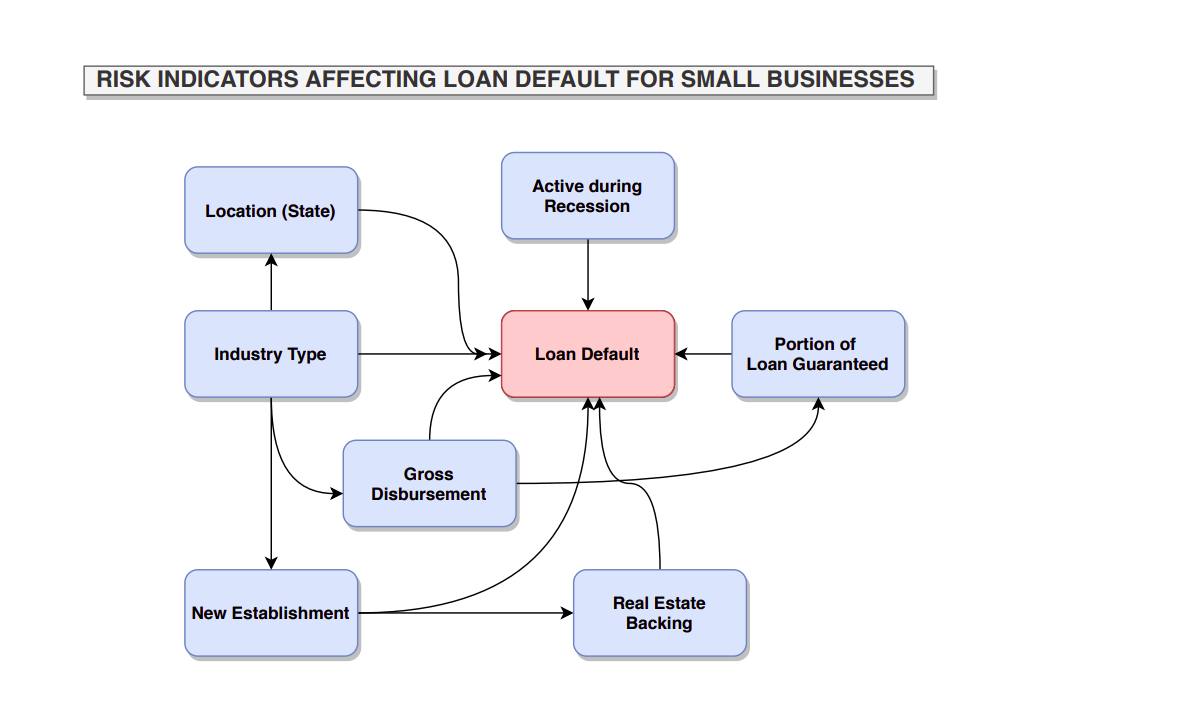

